## Numerical integration: Composite quadrature rules

As usual, we import the necessary modules before we get started.

In [1]:
%matplotlib inline

import numpy as np
from numpy import pi
from math import sqrt
from numpy.linalg import solve, norm    # Solve linear systems and compute norms

import matplotlib.pyplot as plt
import matplotlib.cm as cm  

#import ipywidgets as widgets
#from ipywidgets import interact, fixed

newparams = {'figure.figsize': (16.0, 8.0), 
             'axes.grid': True,
             'lines.markersize': 8, 
             'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
#plt.xkcd()

### General construction of quadrature rules
In the following, you will learn the steps on how to construct realistic
algorithms for numerical integration, similar to those used in software like
Matlab of SciPy.  The steps are:

**Construction.**

1. Choose $n+1$ distinct nodes on a standard interval $I$, often chosen to be $I=[-1,1]$.

2. Let $p_n(x)$ be the polynomial interpolating some general function $f$ in the nodes, and let the  $Q[f](-1,1)=I[p_n](-1,1)$.

3. Transfer the formula $Q$ from $[-1,1]$ to some interval $[a,b]$.

4. Design a composite formula, by dividing the interval $[a,b]$ into
  subintervals and applying the quadrature formula on each subinterval.

5. Find an expression for the error $E[f](a,b) = I[f](a,b)-Q[f](a,b)$. 

6. Find an expression for an estimate of the error, and use this to create an adaptive algorithm.


In this course, we will not have the time to cover the last two steps.

### Constructing quadrature rules on a single interval

We have already seen in the previous Lecture how quadrature rules
on a given interval $[a,b]$ can be constructed using polynomial
interpolation.

For $n+1$ quadrature points $\{x_i\}_{i=0}^n \subset [a,b]$,
we compute weights by

$$
w_i =\int_a^b \ell_i(x) {\,\mathrm{d}x} \quad \text{for } i = 0, \ldots, n.
$$

where $\ell_i(x)$ are the cardinal functions associated with
$\{x_i\}_{i=0}^n$ satisfying $\ell_i(x_j) = \delta_{ij}$ for
$i,j = 0,1,\ldots, n$.
The resulting quadrature rule has (at least) degree of exactness
equal to $n$.

But how to you proceed if you know want to
compute an integral on a different interval, say
$[c,d]$?
Do we have to reconstruct all the cardinal functions and recompute
the weights?

The answer is NO! One can easily transfer quadrature points and weights
from one interval to another.
One typically choose the simple **reference interval** $\widehat{I} = [-1, 1]$.
Then you determine some $n+1$ quadrature points
$\{\widehat{x}_i\}_{i=0}^n \subset [-1,1]$ and quadrature weights
$\{\widehat{w}_i\}_{i=0}^n$ to define a quadrature rule $Q(\widehat{I})$

The quadrature points can then be transferred to an arbitrary interval
$[a,b]$ to define a quadrature rule $Q(a,b)$ using the transformation

$$
x = \frac{b-a}{2}\widehat{x} + \frac{b+a}{2}, \quad  \text{so} \quad {\,\mathrm{d}x} = \frac{b-a}{2}\,\mathrm{d}\widehat{x},
$$

and thus we define
$\{x_i\}_{i=0}^n$
and
$\{w_i\}_{i=0}^n$ by

$$
x_i = \frac{b-a}{2}\widehat{x}_i + \frac{b+a}{2}, \quad  w_i = \frac{b-a}{2}\widehat{w}_i
\quad \text{for } i = 0, \ldots n.
$$

***Example: Simpson's rule***

* Choose standard interval $[-1,1]$. For Simpson's rule, choose the
  nodes $x_0=-1$, $x_1=0$ and $x_2=1$.  The corresponding cardinal
  functions are

  * $\displaystyle \ell_0 = \frac{1}{2}(x^2-x), \qquad \ell_1(x) = 1-x^2, \qquad \ell_2(x) = \frac{1}{2}(x^2+x). $

  which gives the weights

  * $\displaystyle
    w_0 = \int_{-1}^1 \ell_0(x)dx = \frac{1}{3}, \qquad
    w_1 = \int_{-1}^1 \ell_1(x)dx = \frac{4}{3}, \qquad
    w_2 = \int_{-1}^1 \ell_2(x)dx = \frac{1}{3}$

  such that

  * $ \displaystyle \int_{-1}^1 f(t) dx \approx \int_{-1}^1 p_2(x) dx = \sum_{i=0}^2 w_i f(x_i) = \frac{1}{3} \left[\; f(-1) + 4 f(0) + f(1) \; \right].$

* After transferring the nodes and weights,
  Simpson's rule over the interval $[a,b]$ becomes

  * $\displaystyle S(a,b) = \frac{b-a}{6}\left[\; f(a)+4f(c)+f(b)\; \right], \qquad c=\frac{b+a}{2}$.

### Composite quadrature rules
To generate more accurate quadrature rule $Q(a,b)$
we have in principle two possibilities:
* Increase the order of the interpolation polynomial used to construct the quadrature rule.

* Subdivide the interval $[a,b]$ into smaller subintervals and apply a quadrature rule on each of
  the subintervals, leading to **Composite Quadrature Rules** which we will consider next.

In [24]:
colors = plt.get_cmap("Pastel1").colors

def plot_cqr_examples(m):
    f = lambda x : np.exp(x)
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(fig.get_size_inches()[0]*1)
    #axs[0].add_axes([0.1, 0.2, 0.8, 0.7])
    a, b = -0.5,0.5
    l, r = -1.0, 1.0
    x_a = np.linspace(a, b, 100)
    

    for ax in axs:
        ax.set_xlim(l, r)
        x = np.linspace(l, r, 100)
        ax.plot(x, f(x), "k--", label="$f(x)$")
        #ax.fill_between(x_a, f(x_a), alpha=0.1, color='k')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks([a,b])
        ax.set_xticklabels(["$a$", "$b$"])
        ax.set_yticks([])
        ax.legend(loc="upper center")
    
    h = (b-a)/m
    # Compute center points for each interval
    xcs = np.linspace(a+h/2, b-h/2, m)
    xis = np.linspace(a,b,m+1)
    

    # Midpoint rule
    axs[0].bar(xis[:-1], f(xcs), h, align='edge', color=colors[2], edgecolor="black")
    axs[0].plot(xcs,f(xcs), 'ko', markersize=f"{6*(m+1)/m}")
    axs[0].set_title("Composite midpoint rule")


    # Trapezoidal rule
    axs[1].set_title("Composite trapezoidal rule")
    axs[1].fill_between(xis, f(xis), alpha=0.8, color=colors[4])
    axs[1].plot(xis,f(xis), 'ko', markersize=f"{6*(m+1)/m}")
    plt.vlines(xis, 0, f(xis), colors="k")
    plt.show()

In [25]:
import ipywidgets as widgets
from ipywidgets import interact

slider = widgets.IntSlider(min = 1,
                           max = 20,
                           step = 1,
                           description="Number of subintervals m",
                           value = 1)
interact(plot_cqr_examples, m=slider)


interactive(children=(IntSlider(value=1, description='Number of subintervals m', max=20, min=1), Output()), _d…

<function __main__.plot_cqr_examples(m)>

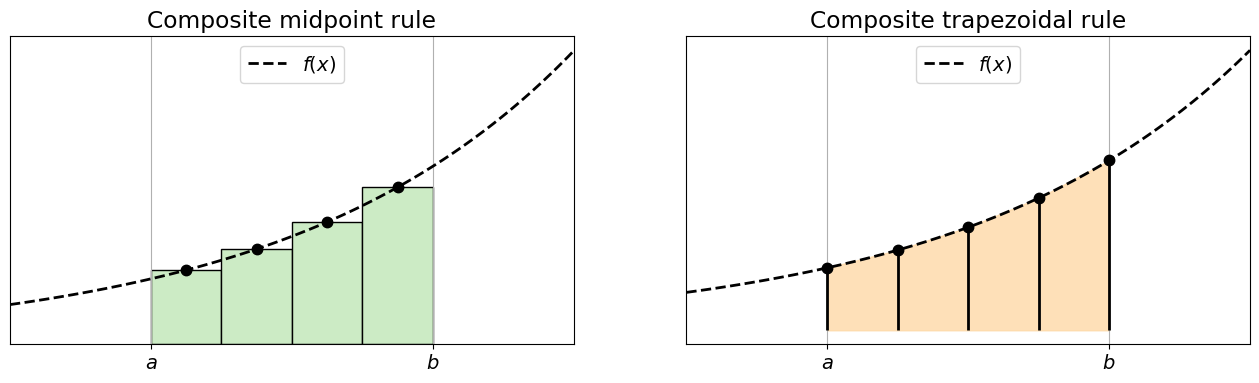

In [26]:
m = 4
plot_cqr_examples(m)

Select $m \geqslant 2$ and divide $[a,b]$ into $m$ equally spaced
subintervals $[x_{i-1}, x_{i}]$ defined by $x_i = a + i h$ with $h =
(b-a)/m$ for $i=1,\ldots, m$.
Then for a given quadrature rule $\mathrm{Q}[\cdot](x_{i-1},x_i)$ the corresponding
composite quadrature rule $\mathrm{CQ}[\cdot]({[x_{i-1}, x_{i}]}_{i=1}^{m})$ is given by

\begin{equation}
\int_a^b f {\,\mathrm{d}x} \approx \mathrm{CQ}[f]({[x_{i-1}, x_{i}]}_{i=1}^{m}) = \sum_{i=1}^m \mathrm{Q}[f](x_{i-1},x_i).
\end{equation}(eqquad:composite_qr}

## Composite trapezoidal rule
Using the trapezoidal rule

$$
\mathrm{T}[f](x_{i-1},x_{i})
=
\tfrac{h}{2} f(x_{i-1}) + \tfrac{h}{2} f(x_{i})
$$
the resulting composite trapezoidal rule is given by

\begin{align*}
\int_a^b f {\,\mathrm{d}x} \approx \mathrm{CT}[f]({[x_{i-1}, x_{i}]}_{i=1}^{m})
= h \left[ \tfrac{1}{2} f(x_0) + f(x_1) + \ldots + f(x_{m-1}) + \tfrac{1}{2} f(x_m) \right]
\end{align*}


:::{exercise-start} Testing the accuracy of the composite trapezoidal rule
:label: exe-test-accur-ctr
:::

Have a look at the `CT` function which implements the composite trapezoidal rule:

In [ ]:
def CT(f, a, b, m):
    """ Computes an approximation of the integral f
    using the composite trapezoidal rule.
    Input:
        f:  integrand
        a:  left interval endpoint
        b:  right interval endpoint
        m:  number of subintervals
    """
    x = np.linspace(a,b,m+1)
    h = float(b - a)/m
    fx = f(x[1:-1])
    ct = h*(np.sum(fx) + 0.5*(f(x[0]) + f(x[-1])))
    return ct

Use this function to compute an approximate value of integral

$$
I(0,1) = \int_0^1 \cos\left(\frac{\pi}{2}x\right) = \frac{2}{\pi} = 0.636619\dotsc.
$$

for $m = 4, 8, 16, 32, 64$ corresponding to
$ h = 2^{-2}, 2^{-3}, 2^{-4}, 2^{-5}, 2^{-6}$.
Tabulate the corresponding quadrature errors $I(0,1) - Q(0,1)$.
What do you observe?

:::{exercise-end}
:::

In [ ]:
# Insert your code here

:::{solution} exe-test-accur-ctr
:class: dropdown

:::{code-block} python
# Define function
def f(x):
    return np.cos(pi*x/2)

# Exact integral
int_f = 2/pi 

# Interval
a, b = 0, 1

# Compute integral numerically
for m in [4, 8, 16, 32, 64]:
    cqr_f = CT(f, a, b, m)
    print(f"I[f] = {int_f}")
    print(f"Q[f, {a}, {b}, {m}] = {qr_f}")
    print(f"I[f] - Q[f] = {int_f - qr_f:.3e}")

:::

:::

:::{prf:remark}

We observe that for each *doubling* of the number of subintervals
we decrease the error by a *fourth*.
That means that if we look at
the quadrature error $I[f]-\mathrm{CT}[f]$
as a function of the number of subintervals $m$
(or equivalently as a function of $h$),
then
$|I[f]-\mathrm{CT}[f]| \approx \tfrac{C}{m^2} = C h^2$.

:::

### Error estimate for the composite trapezoidal rule
We will now theoretically explain the experimentally observed
convergence rate in the previous {ref}`exe-test-accur-ctr`.

First we have to recall the error estimate for
for the trapezoidal rule on a single interval $[a,b]$.
If $f\in C^2(a,b)$, then there is a $\xi \in (a,b)$ such that

$$
I[f]-\mathrm{T}[f]=\frac{(b-a)^3}{12}f''(\xi).
$$

:::{prf:theorem} Quadrature error estimate for composite trapezoidal rule
:label: thm-ctr-error-est

Let $f\in C^2(a,b)$, then
the quadrature error $I[f]-\mathrm{CT}[f]$
for the composite trapezoidal rule can be estimated by

\begin{equation}
|I[f]-\mathrm{CT}[f]|
\leqslant
\dfrac{M_2}{12} \dfrac{(b-a)^3}{m^2}
=
\dfrac{M_2}{12}
h^2(b-a)
\label{quad:thm:ctr_est} \tag{2}
\end{equation}

where  $M_2 = \max_{\xi\in[a,b]} |f''(\xi)|$.
:::

:::{prf:proof}
:class: dropdown

$$
\begin{align*}
|I[f]-\mathrm{CT}[f]|
&=
\biggl \lvert
\sum_{i=1}^m
\Bigl [
\int_{x_{i-1}}^{x_i} f(x) {\,\mathrm{d}x}
- \bigl(
\tfrac{h}{2}f(x_{i-1})
+
\tfrac{h}{2}f(x_{i})
\bigr)
\Bigr]
\biggr \rvert
\\ 
&\leqslant
\sum_{i=1}^m
\frac{h^3}{12}|f''(\xi_i)|
\leqslant 
M_2 \sum_{i=1}^m
\frac{(h)^3}{12}
\\ 
&=
M_2 
\frac{h^3}{12}
\underbrace{m}_{\tfrac{(b-a)}{h}}
=
\dfrac{M_2}{12}
h^2(b-a)
=
\frac{M_2}{12}
\frac{(b-a)^3}{m^2}
\end{align*}.
$$

:::

### Interlude: Convergence of $h$-dependent approximations

Let $X$ be the exact solution, and $X(h)$ some numerical solution depending on a
parameter $h$, and let $e(h)$ be the norm of the error, so $e(h)=\|X-X(h)\|$. The numerical approximation $X(h)$ converges to $X$ if $e(h) \rightarrow 0$ as $h\rightarrow 0$. 
The order of the approximation is $p$ if there exists a positive constant $M$ such that
$$
e(h) \leq M h^p
$$

The Big $\mathcal{O}$-notation we can simply write
$$
e(h) = \mathcal{O}(h^p)
\qquad\text{ as } h \to 0.
$$
This is often used when we are not directly interested in any expression for the constant $M$, we only need to know it exists.

Again, we see that a higher approximation order $p$ leads for small values of $h$ to a better approximation of the solution. Thus we are generally interested in approximations of higher order.

**Numerical verification**

The following is based on the assumption that  $e(h)\approx C h^p$ for some
unknown constant $C$. This assumption is often reasonable for sufficiently
small $h$. 

Choose a test problem for which the exact solution is known and compute the
error for a decreasing sequence of $h_k$'s, for instance $h_k=H/2^k$,
$k=0,1,2,\dots$. The procedure is then quite similar to what was done for
iterative processes.

$$
\begin{array}{rcl} e(h_{k+1}) &\approx& C h_{k+1}^p \\  e(h_k) &\approx& C h_k^p \end{array}
  \qquad \Rightarrow \qquad 
  \frac{e(h_{k+1})}{e(h_k)} \approx \left( \frac{h_{k+1}}{h_k} \right)^p 
  \qquad \Rightarrow \qquad 
  p \approx \frac{\log{(e(h_{k+1})/e(h_k))}}{\log{(h_{k+1}/h_k)}}
$$

For one refinement step where one passes from $h_k \to h_{k+1}$, the number
$$
EOC(k) \approx \frac{\log{(e(h_{k+1})/e(h_k))}}{\log{(h_{k+1}/h_k)}}
$$
is often called the "Experimental order of convergence at refinement level k"

Since
$$
e(h) \approx Ch^p \qquad \Rightarrow \qquad 
\underbrace{\log{e(h)}}_{y} \approx \underbrace{\log{C}}_{a} + p \underbrace{\log{h}}_{x}
$$
a plot of $e(h)$ as a function of $h$ using a logarithmic scale on both axes (a log-log plot)
will be a straight line with slope $p$. Such a plot is referred to as
an *error plot* or a *convergence plot*.

:::{exercise} Convergence order of composite trapezoidal rule
:label: exe-ctr-eoc
Examine the convergence order of composite trapezoidal rule.

:::

In [ ]:
# Insert your code here.

:::{solution} exe-ctr-eoc

:::{code-block} python
# Define function
def f(x):
    return np.cos(pi*x/2)

# Exact integral
int_f = 2/pi 

# Interval
a, b = 0, 1

errs = []
hs = []

# Compute integral numerically
for m in [4, 8, 16, 32, 64]:
    cqr_f = CT(f, a, b, m)
    print("Number of subintervals m = {}".format(m))
    print("Q[f] = {}".format(cqr_f))
    err = int_f - cqr_f
    errs.append(err)
    hs.append((b-a)/m)
    print("I[f] - Q[f] = {:.10e}".format(err))

hs = np.array(hs)
errs = np.array(errs)

eocs = np.log(errs[1:]/errs[:-1])/np.log(hs[1:]/hs[:-1])
print(eocs)
plt.loglog(hs, errs, "bo-")
plt.xlabel("log(h)")
plt.ylabel("log(err)")

# Adding infinity in first row to eoc list
# to make it the same length as errs
eocs = np.insert(eocs, 0, np.inf)
:::


In [ ]:
# Define function
def f(x):
    return np.cos(pi*x/2)

# Exact integral
int_f = 2/pi 

# Interval
a, b = 0, 1

errs = []
hs = []

# Compute integral numerically
for m in [4, 8, 16, 32, 64]:
    cqr_f = CT(f, a, b, m)
    print("Number of subintervals m = {}".format(m))
    print("Q[f] = {}".format(cqr_f))
    err = int_f - cqr_f
    errs.append(err)
    hs.append((b-a)/m)
    print("I[f] - Q[f] = {:.10e}".format(err))

hs = np.array(hs)
errs = np.array(errs)

eocs = np.log(errs[1:]/errs[:-1])/np.log(hs[1:]/hs[:-1])
print(eocs)
plt.figure(figsize=(6, 3)) 
plt.loglog(hs, errs, "bo-")
plt.xlabel("log(h)")
plt.ylabel("log(err)")

# Adding infinity in first row to eoc list
# to make it the same length as errs
eocs = np.insert(eocs, 0, np.inf)

In [ ]:
# Do a pretty print of the tables using panda
import pandas as pd
#from IPython.display import display

table = pd.DataFrame({'Error': errs, 'EOC' : eocs})
display(table)
print(table)

:::{exercise} Composite Simpson's rule

The composite Simpson's rule is considered in detail in homework assignment 2.

:::

:::{prf:theorem} Quadrature error estimate for composite Simpon's rule
:label: thm-csr-err-estim
Let $f\in C^4(a,b)$, then
the quadrature error $I[f]-\mathrm{CT}[f]$
for the composite trapezoidal rule can be estimated by

\begin{equation}
|I[f]-\mathrm{CSR}[f]|
\leqslant
\dfrac{M_4}{2880} \dfrac{(b-a)^5}{m^4}
=
\dfrac{M_4}{2880}
h^4(b-a)
\label{quad:thm:csr_est} \tag{3}
\end{equation}

where  $M_4 = \max_{\xi\in[a,b]} |f^{(4)}(\xi)|$.
:::


**Proof.**

*Will be part of homework assignment 2.*